# Data Exploration of joint dataset

Here I will look at both cities in one DF to see if it make more sense to keep our data model as a collective dataset.

In [2]:
import pandas as pd
df_features = pd.read_csv("../data/raw/DengAI_Predicting_Disease_Spread_-_Training_Data_Features.csv")

df_features['city_col'] = df_features['city']
df_features['year_col'] = df_features['year']
df_features['weekofyear_col'] = df_features['weekofyear']

df_features.set_index(['city', 'year', 'weekofyear'], inplace=True)

labels = pd.read_csv("../data/raw/DengAI_Predicting_Disease_Spread_-_Training_Data_Labels.csv", index_col=[0, 1, 2])


# add target to features
df_combined = df_features.join(labels)

#filter for sj city
sj = df_combined[df_combined['city_col'] == "sj"]

df_combined.columns

Index(['week_start_date', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
       'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'city_col', 'year_col',
       'weekofyear_col', 'total_cases'],
      dtype='object')

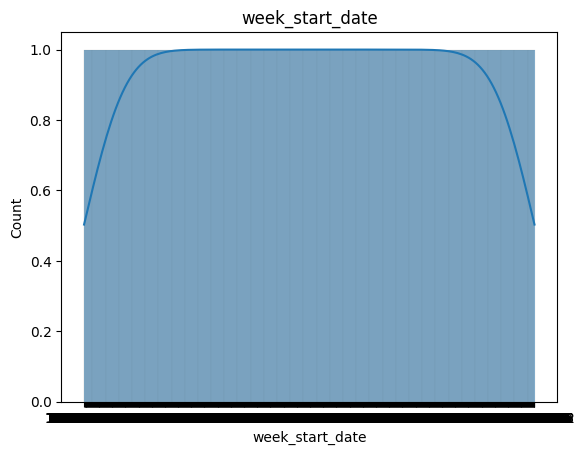

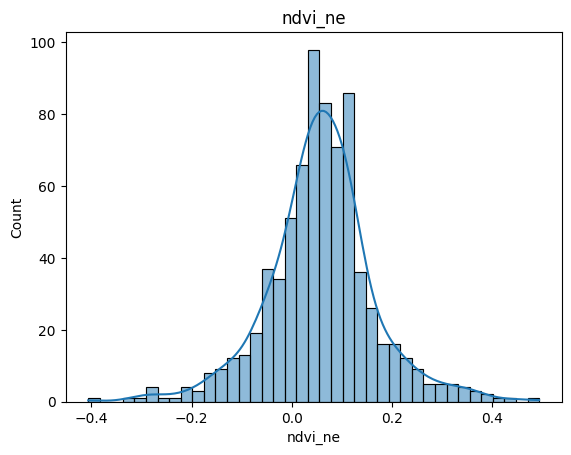

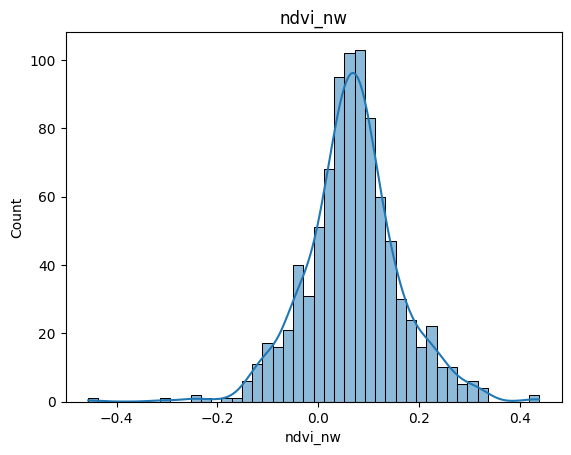

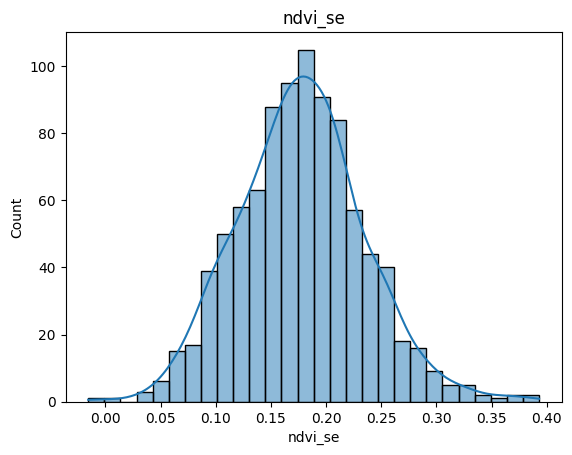

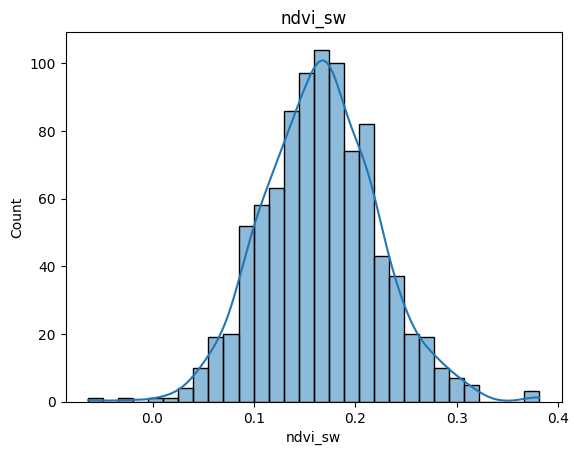

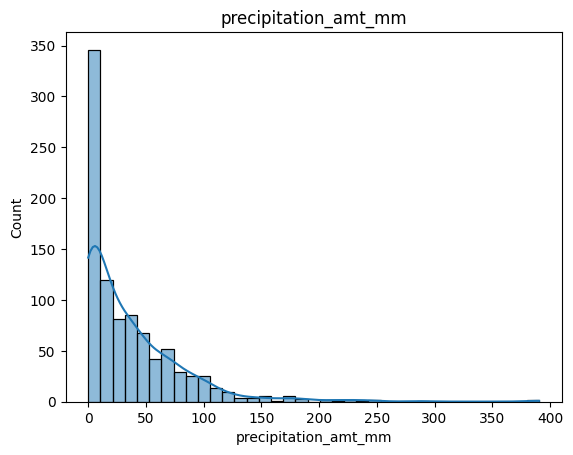

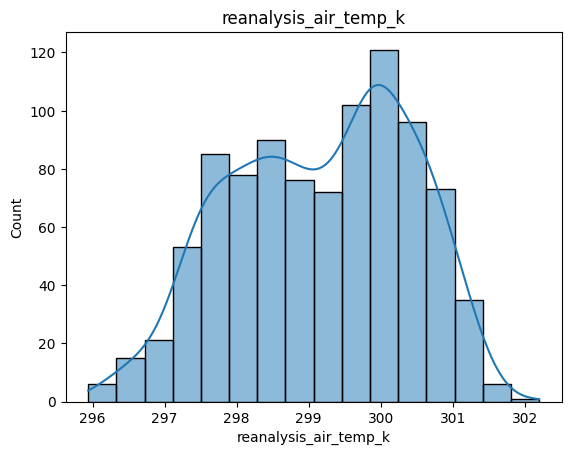

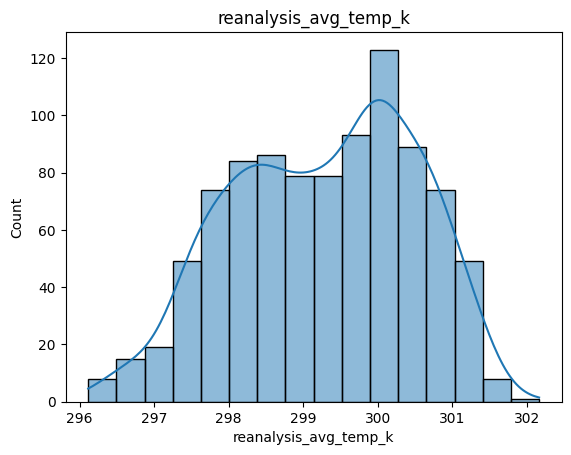

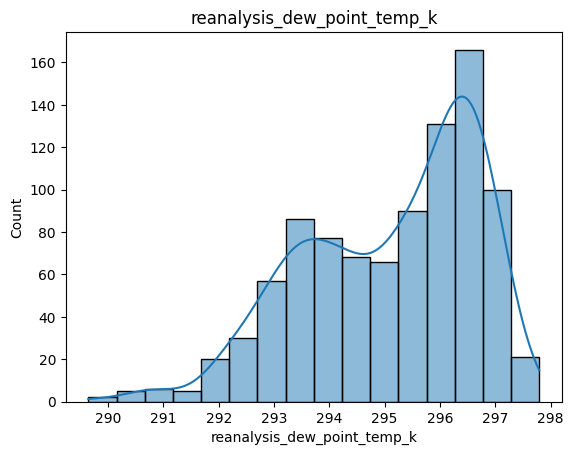

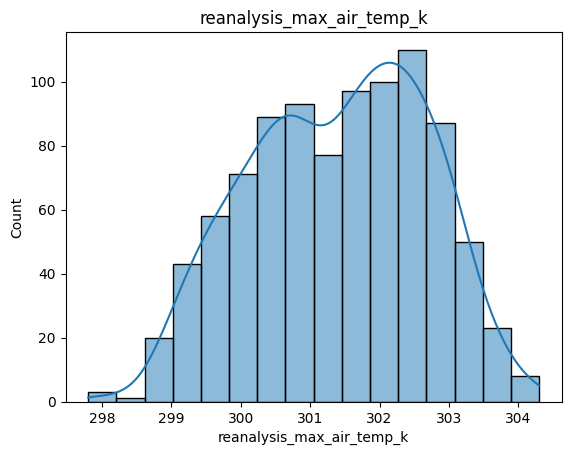

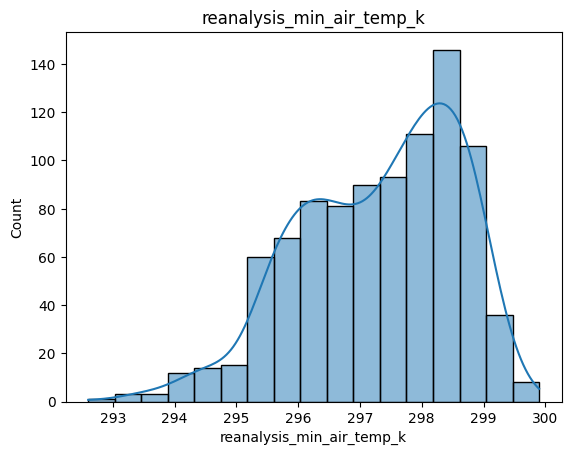

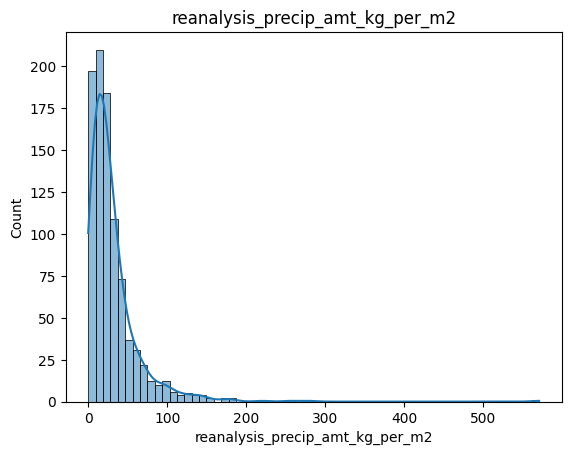

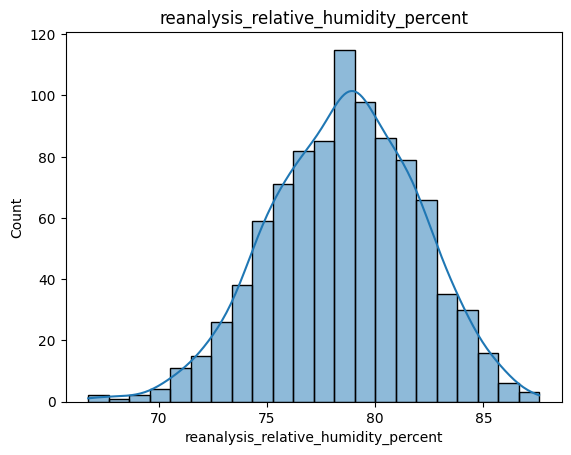

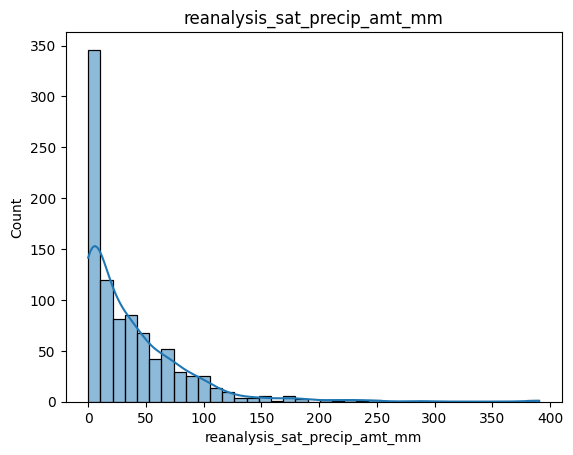

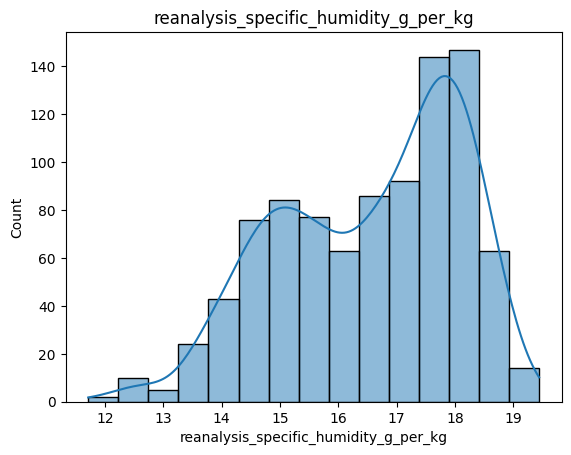

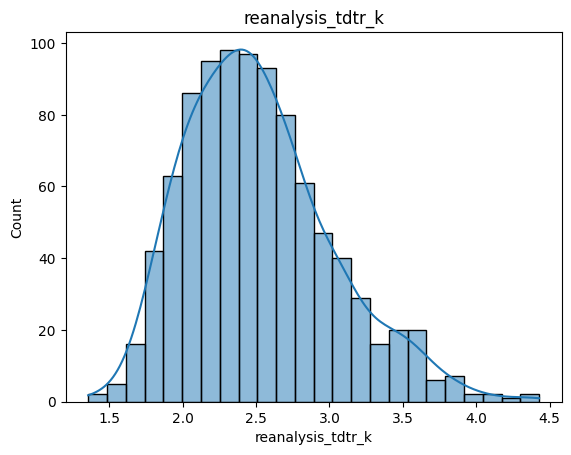

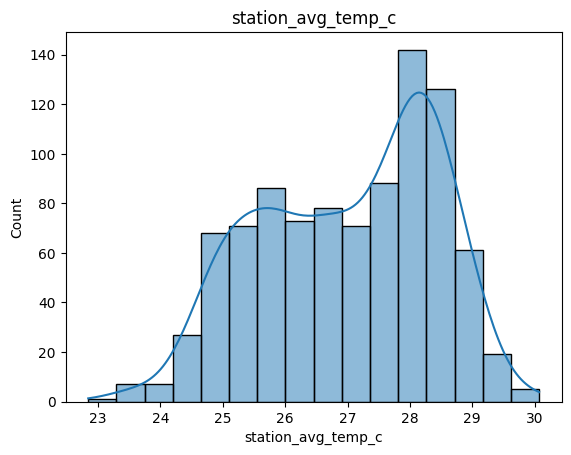

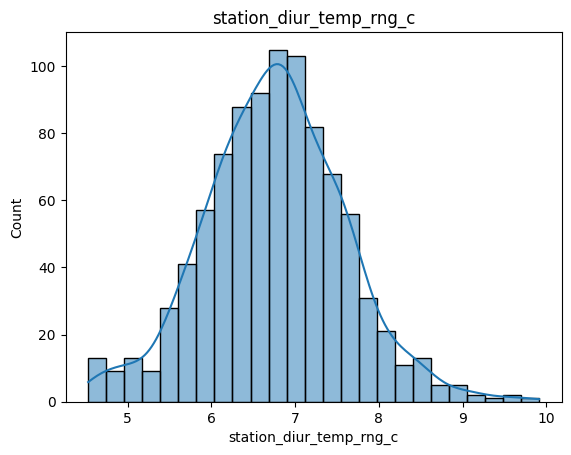

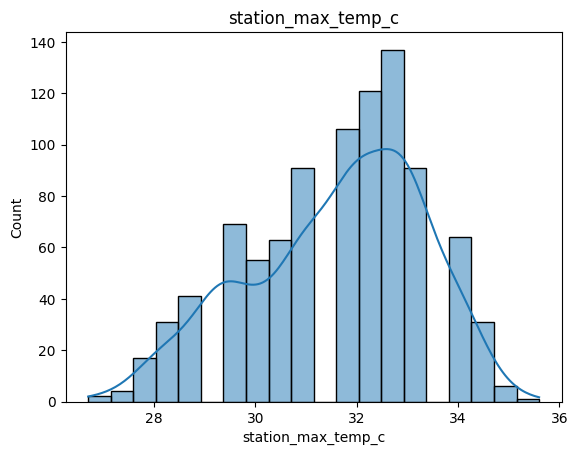

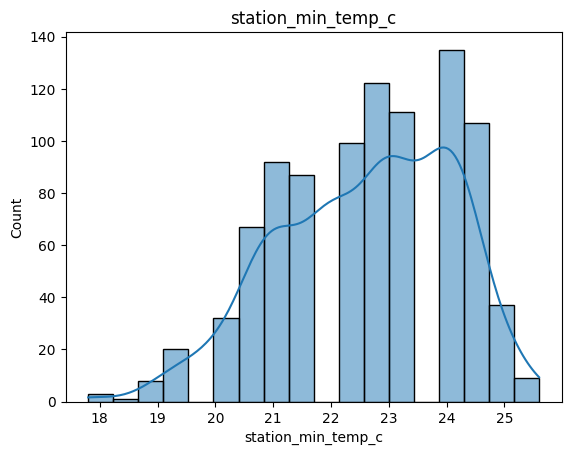

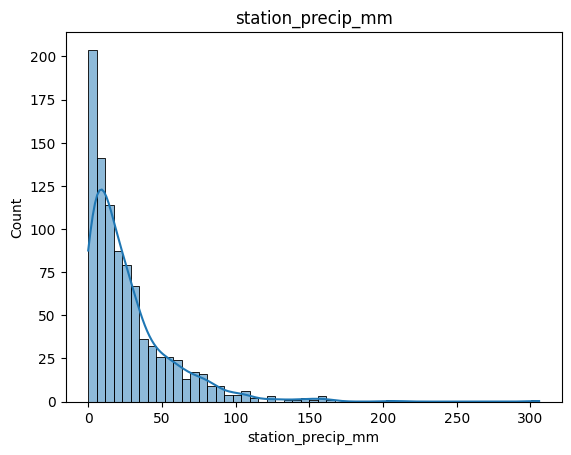

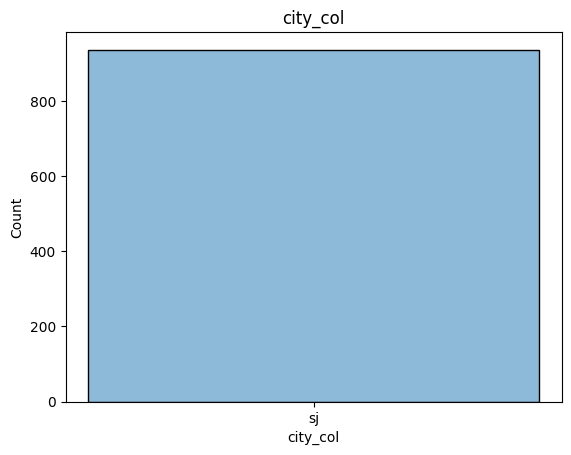

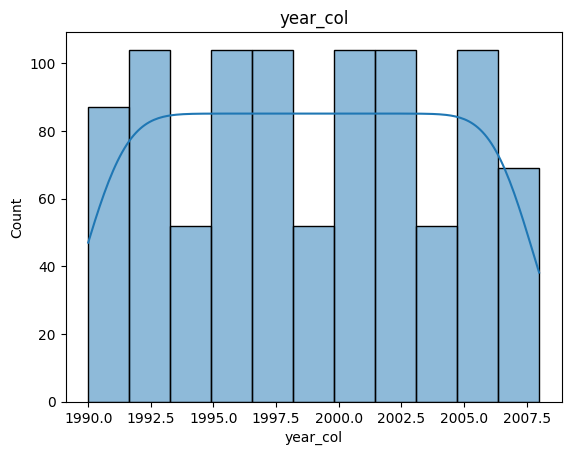

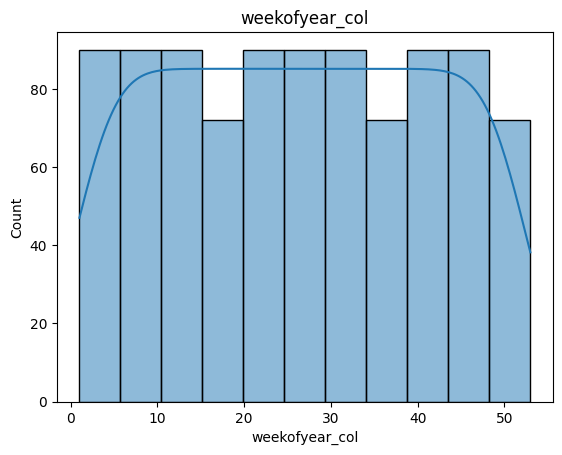

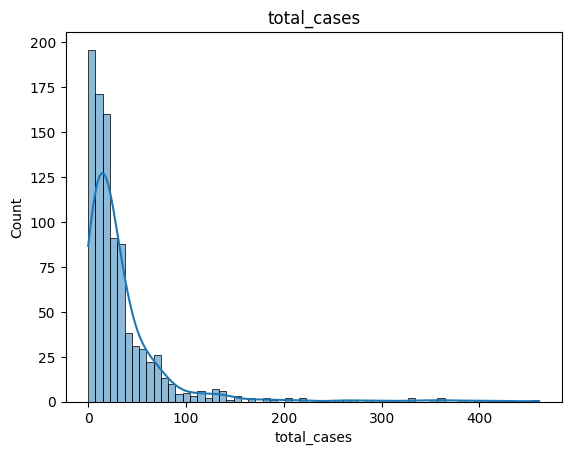

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

df = sj

for  col in df_combined.columns:
    sns.histplot(df[col], kde=True)
    plt.title(col)
    plt.show()

In [4]:
sj.dtypes

week_start_date                           object
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rng_c                  float64
station_max_temp_c                       float64
station_min_temp_c                       float64
station_precip_mm   

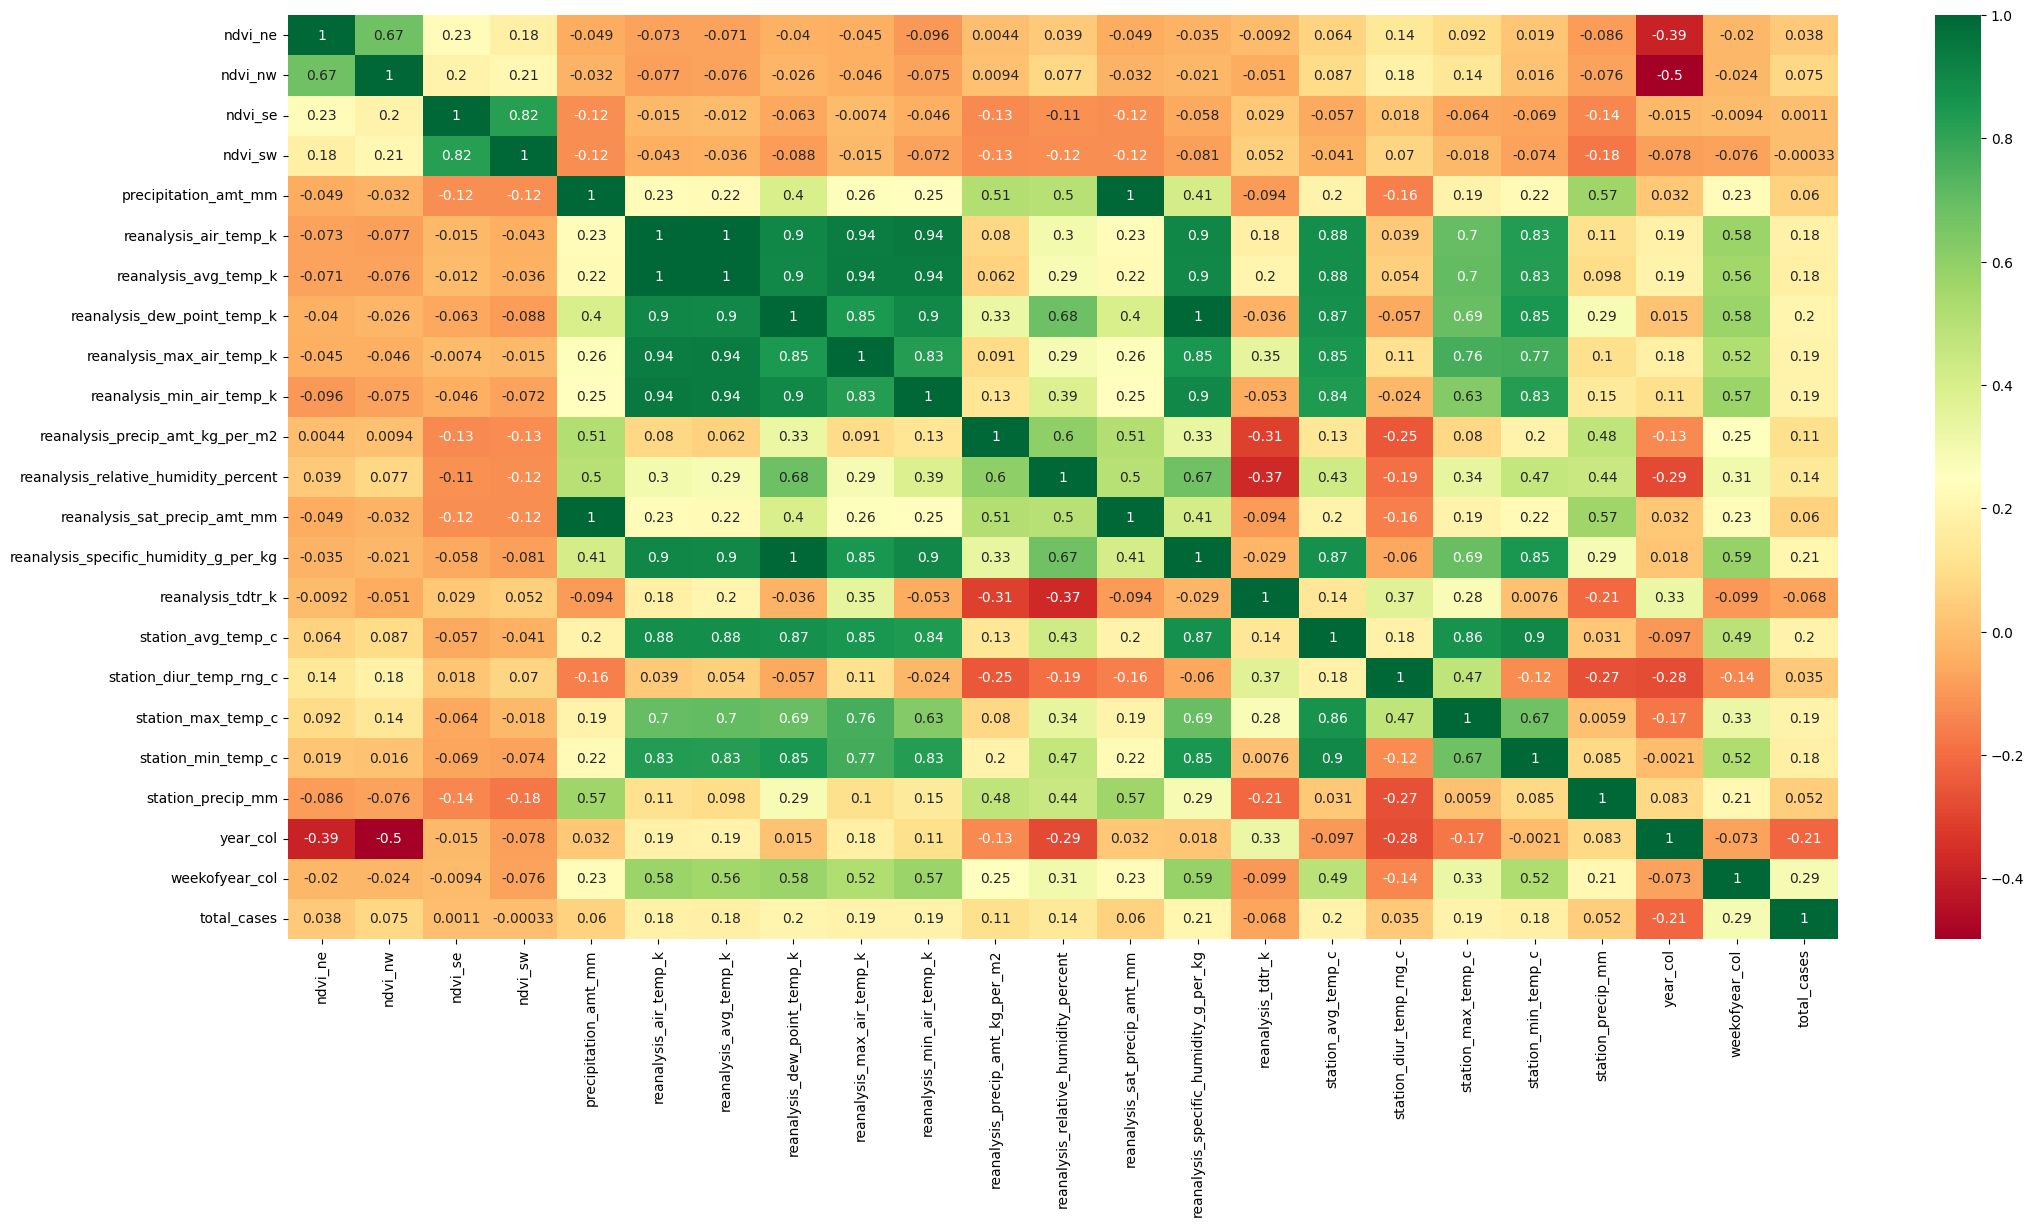

In [5]:
# drop object types for now so we can get basic correlations
sj = sj.drop(["week_start_date", "city_col"], axis=1)

corrmat = sj.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(25,12))

#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [6]:
print("Index names:", sj.index.names)
print("Index type:", type(sj.index))
print("First few index values:", sj.index[:5])

Index names: ['city', 'year', 'weekofyear']
Index type: <class 'pandas.core.indexes.multi.MultiIndex'>
First few index values: MultiIndex([('sj', 1990, 18),
            ('sj', 1990, 19),
            ('sj', 1990, 20),
            ('sj', 1990, 21),
            ('sj', 1990, 22)],
           names=['city', 'year', 'weekofyear'])


In [7]:
# from sklearn.impute import KNNImputer

# imputer = KNNImputer(n_neighbors=)

sj['total_cases_3wk_before'] = sj.groupby(level=0)['total_cases'].shift(2)

# sj['total_cases_lag2'] = imputer.fit_transform(sj[['total_cases_lag2']]).flatten()

# This gives as a weird fill with very high values, so lets try another strategy.

sj['total_cases_3wk_before'].fillna(sj['total_cases'], inplace=True)

sj

print(sj[['total_cases', 'total_cases_3wk_before']].head(10))

                      total_cases  total_cases_3wk_before
city year weekofyear                                     
sj   1990 18                    4                     4.0
          19                    5                     5.0
          20                    4                     4.0
          21                    3                     5.0
          22                    6                     4.0
          23                    2                     3.0
          24                    4                     6.0
          25                    5                     2.0
          26                   10                     4.0
          27                    6                     5.0


/var/folders/10/hcdntc992dn9bk_63vcc9q8w0000gn/T/ipykernel_48311/1114154124.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sj['total_cases_3wk_before'].fillna(sj['total_cases'], inplace=True)


In [ ]:
import numpy as np
df_temp = sj.reset_index()
df_temp = df_temp.sort_values(['city', 'year', 'weekofyear'])
df_temp['total_cases_lag2'] = df_temp.groupby('city')['total_cases'].shift(-3)
sj = df_temp.set_index(['city', 'year', 'weekofyear'])

sj['total_cases_3wk_before'].fillna(sj['total_cases'], inplace=True)

print(sj[['total_cases', 'total_cases_3wk_before']].head(10))

sj['total_cases_log'] = np.log1p(sj['total_cases'])  # log1p = log(1 + x)
sj['total_cases_log_lag2'] = sj.groupby(level=0)['total_cases_log'].shift(-2)
sj['total_cases_log_lag3'] = sj.groupby(level=0)['total_cases_log'].shift(-3)

sj['temp_suitability_aug_lag3'] = (sj.groupby(level=0)['station_avg_temp_c'].shift(3).transform(lambda x: (x - 27.5) / 27))
sj['humid_temp_index'] = sj.groupby(level=0)['reanalysis_relative_humidity_percent'].shift(4) * sj.groupby(level=0)['reanalysis_avg_temp_k'].shift(4)

ndvi_cols = ['ndvi_se', 'ndvi_sw', 'ndvi_ne', 'ndvi_nw']

sj['ndvi_heterogeneity'] = (
    sj.groupby(level=0)[ndvi_cols]
    .apply(lambda group: group.std(axis=1))
    .reset_index(level=0, drop=True)
    .squeeze()  # ensures it’s a Series, not a DataFrame
)


sj['saturation_deficit_lag3'] = (
    sj['reanalysis_air_temp_k'].shift(3) - sj['reanalysis_dew_point_temp_k'].shift(3)
)

sj['saturation_deficit_lag2'] = (
    sj['reanalysis_air_temp_k'].shift(2) - sj['reanalysis_dew_point_temp_k'].shift(2)
)

sj['thermal_stress'] = (
    sj['station_diur_temp_rng_c'].shift(3) / sj['station_avg_temp_c'].shift(3)
)
sj

                      total_cases  total_cases_3wk_before
city year weekofyear                                     
sj   1990 18                    4                     4.0
          19                    5                     5.0
          20                    4                     4.0
          21                    3                     5.0
          22                    6                     4.0
          23                    2                     3.0
          24                    4                     6.0
          25                    5                     2.0
          26                   10                     4.0
          27                    6                     5.0


/var/folders/10/hcdntc992dn9bk_63vcc9q8w0000gn/T/ipykernel_48311/442362020.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sj['total_cases_3wk_before'].fillna(sj['total_cases'], inplace=True)


ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
city year weekofyear                                           
sj   1990 18          0.122600  0.103725  0.198483  0.177617   
          19          0.169900  0.142175  0.162357  0.155486   
          20          0.032250  0.172967  0.157200  0.170843   
          21          0.128633  0.245067  0.227557  0.235886   
          22          0.196200  0.262200  0.251200  0.247340   
...                        ...       ...       ...       ...   
     2008 13          0.077850 -0.039900  0.310471  0.296243   
          14         -0.038000 -0.016833  0.119371  0.066386   
          15         -0.155200 -0.052750  0.137757  0.141214   
          16          0.001800       NaN  0.203900  0.209843   
          17         -0.037000 -0.010367  0.077314  0.090586   

                      precipitation_amt_mm  reanalysis_air_temp_k  \
city year weekofyear                                                
sj   1990 18                         12.42             297.572857   
          19                         22.82             298.211429   
          20                         34.54             298.781429   
          21                         15.36             298.987143   
          22                          7.52             299.518571   
...                                    ...                    ...   
     2008 13                         27.19             296.958571   
          14                          3.82             298.081429   
          15                         16.96             297.460000   
          16                          0.00             297.630000   
          17                          0.00             298.672857   

                      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
city year weekofyear                                                       
sj   1990 18                     297.742857                   292.414286   
          19                     298.442857                   293.951429   
          20                     298.878571                   295.434286   
          21                     299.228571                   295.310000   
          22                     299.664286                   295.821429   
...                                     ...                          ...   
     2008 13                     296.957143                   292.095714   
          14                     298.228571                   293.235714   
          15                     297.564286                   292.732857   
          16                     297.778571                   292.274286   
          17                     298.692857                   294.280000   

                      reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
city year weekofyear                                                         
sj   1990 18                              299.8                      295.9   
          19                              300.9                      296.4   
          20                              300.5                      297.3   
          21                              301.4                      297.0   
          22                              301.9                      297.5   
...                                         ...                        ...   
     2008 13                              299.7                      294.4   
          14                              299.8                      296.5   
          15                              299.4                      295.8   
          16                              299.7                      295.9   
          17                              300.9                      295.9   

                      ...  total_cases_lag2  total_cases_log  \
city year weekofyear  ...                                      
sj   1990 18          ...               3.0         1.609438   
          19          ...               6.0         1.791759   
          20          ...       

<Axes: >

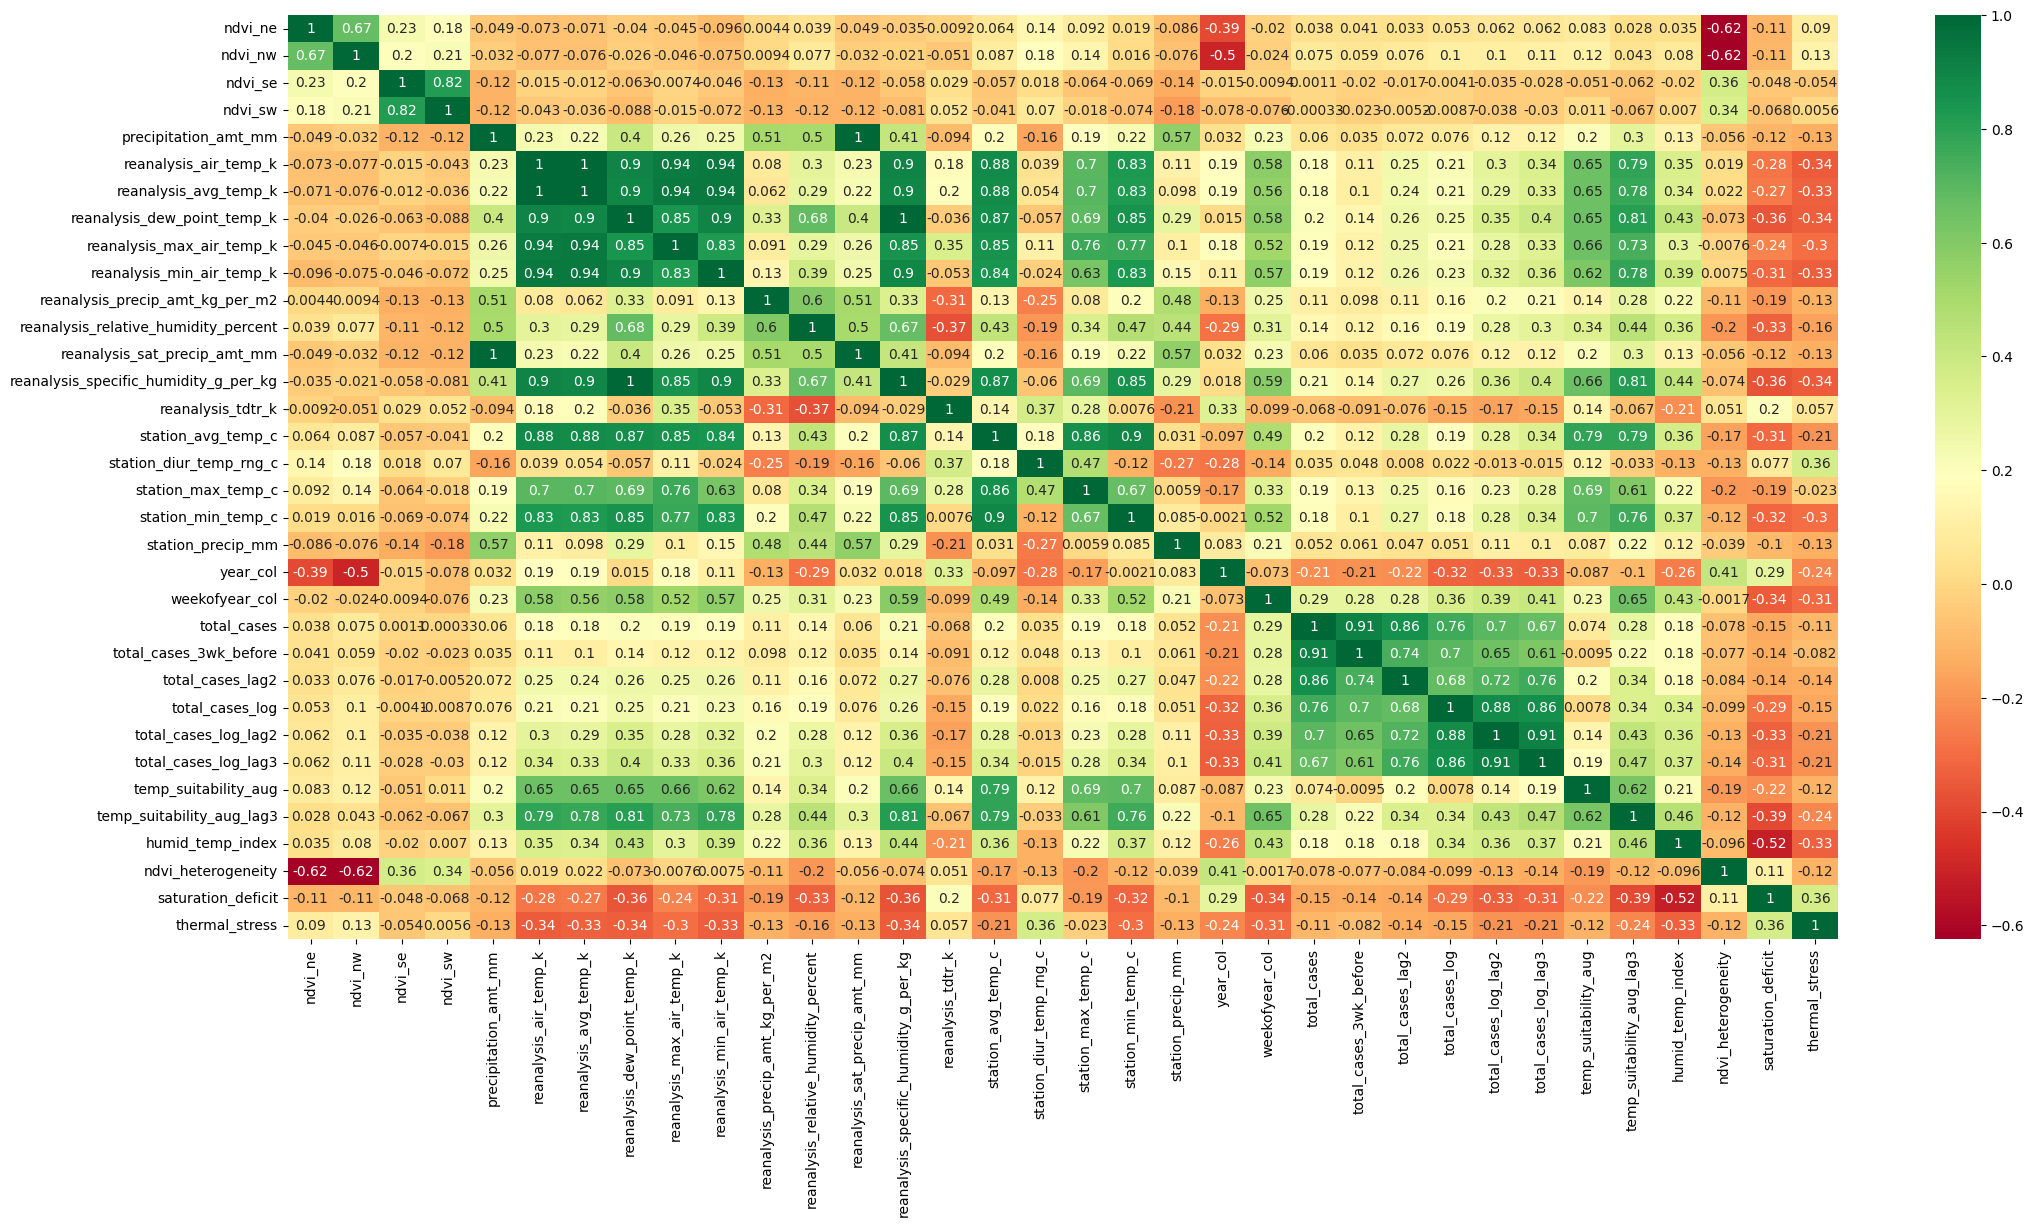

In [47]:


corrmat = sj.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(25,12))

#plot heat map
sns.heatmap(sj[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [44]:
# from sklearn.impute import KNNImputer

# imputer = KNNImputer(n_neighbors=)

sj['total_cases_3wk_before'] = sj.groupby(level=0)['total_cases'].shift(2)

# sj['total_cases_lag2'] = imputer.fit_transform(sj[['total_cases_lag2']]).flatten()

# This gives as a weird fill with very high values, so lets try another strategy.

sj['total_cases_3wk_before'].fillna(sj['total_cases'], inplace=True)

sj

print(sj[['total_cases', 'total_cases_3wk_before']].head(10))

                      total_cases  total_cases_3wk_before
city year weekofyear                                     
sj   1990 18                    4                     4.0
          19                    5                     5.0
          20                    4                     4.0
          21                    3                     5.0
          22                    6                     4.0
          23                    2                     3.0
          24                    4                     6.0
          25                    5                     2.0
          26                   10                     4.0
          27                    6                     5.0


/var/folders/10/hcdntc992dn9bk_63vcc9q8w0000gn/T/ipykernel_48311/1114154124.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sj['total_cases_3wk_before'].fillna(sj['total_cases'], inplace=True)


# 3 Week shift seems to make a biggest difference here.

In [ ]:
##It also seems that the log of total case helps to fix the skew on that distribution.